In [4]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import seaborn as sns
import warnings

from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

warnings.filterwarnings('ignore')
plt.figure(figsize=(10,10))

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [5]:
train_data = pd.read_csv('input/train.csv')

In [6]:
print('train data:', train_data.shape)

train data: (891, 12)


In [7]:
train_data.head(3)

# Based on the columns, PassengerId is the unique id for each passenger. 
# Survived is binary variable: whether survived or not. 
# Pclass: Whether the Pclass is 1,3

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### Missing Data 

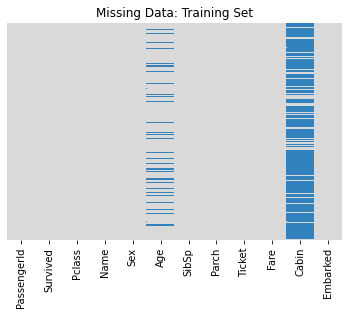

In [9]:
# train_data.isnull() is a binary matrix that is plotted on seaborn heatmap. 
sns.heatmap(train_data.isnull(), yticklabels=False,cbar=False,  cmap = 'tab20c_r')
plt.title('Missing Data: Training Set')
plt.show()

In [44]:
# % of missing data across all the columns 
for i in train_data.columns: 
    print('{}'.format(i), round(sum(train_data[i].isnull())/len(train_data[i]) * 100,2), '%')

PassengerId 0.0 %
Survived 0.0 %
Pclass 0.0 %
Name 0.0 %
Sex 0.0 %
Age 0.0 %
SibSp 0.0 %
Parch 0.0 %
Ticket 0.0 %
Fare 0.0 %
Cabin 77.1 %
Embarked 0.22 %


- Cabin has 77% missing values
- Embarked has 22% missing values
- Age has 20% missing values

### Pairwise deletion: Imputation of the Age values using correlation with passenger class. 

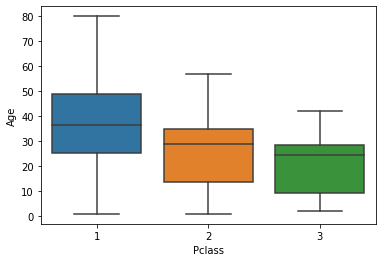

In [29]:
# Check visual evidence of correlation

# Take the rows where the age column in not NA 
train_data = train_data[train_data['Age'].notna()]

sns.boxplot(x='Pclass', y = 'Age', data = train_data)


df_a = train_data[(train_data['Pclass'] == 1)]['Age']
df_b = train_data[(train_data['Pclass'] == 2)]['Age']
df_c = train_data[(train_data['Pclass'] == 3)]['Age']

paired_df = train_data[['Pclass','Age']]


In [30]:
f_oneway(df_a.to_list(), df_b.to_list(), df_c.to_list())

F_onewayResult(statistic=9.762703872790492, pvalue=9.433803581462056e-05)

In [32]:
# Pairwise Tukey HSD test 
tukey = pairwise_tukeyhsd(endog=paired_df['Age'],
                          groups=paired_df['Pclass'],
                          alpha=0.05)
print(tukey)



 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     1      2 -12.3246 0.0073 -21.8651 -2.7841   True
     1      3 -16.5913 0.0023 -28.1059 -5.0766   True
     2      3  -4.2667 0.7444 -18.6828 10.1494  False
-----------------------------------------------------


In [ ]:
# The group means across 2 and 3 are not siginificantly different. 
# Hence, we can impute the Age according to passenger categories such as class 1 and 2+3 but 
# cannot differentiate between 2 and 3. 
# use the same means across passenger class 2 and 3. 

In [39]:
# replace the values for age with the means in the specific groups. 
mean_age_group1 = round(train_data[(train_data['Pclass'] ==1)]['Age'].mean(),2)
mean_age_group2 = round(train_data[(train_data['Pclass'] == 3) | (train_data['Pclass'] == 2)]['Age'].mean(),2)

print(mean_age_group1)
print(mean_age_group2)

38.23
26.69


In [40]:
# Impute the values using the Pclass statistics 
train_data = pd.read_csv('input/train.csv')

# Imputation function
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):

        if Pclass == 1:
            return 38

        elif Pclass == 2 or Pclass == 3:
            
            return 27

    else:
        return Age
    
# Apply the function to the Age column
train_data['Age']=train_data[['Age','Pclass']].apply(impute_age, axis =1 )    